# The Physical Layer as an Autoencoder


**First : change the runtime and hardware acceleration**

Runtime $\rightarrow$ Change runtime type

- Runtime type : Python 3
- Hardware accelerator : GPU

An autoencoder is a type of artificial neural network used to find a useful representation of some data $\mathbf{s}$ at an intermediate layer $\mathbf{x}$ through learning to reproduce the input at the output.

![autoencoder_0](https://github.com/mgoutay/autoencodeur/blob/master/Images/autoencoder_0.png?raw=true)



# Initialisation

In [1]:
# Install TensorFlow 2.0 on Google Collab if needed
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [2]:
#Set the GPU you want to use
num_GPU = 0

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))

if num_GPU < len(gpus):
    tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
    print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.0.0
Number of GPUs available : 4
Only GPU number 0 used


In [17]:
import os
import copy
import sys
import time
from datetime import datetime

import numpy as np
import matplotlib
import matplotlib.pyplot as plt  

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, Softmax
from tensorflow.keras.regularizers import Regularizer

# Communicating messages

**An autoencoder-based communication systems aims to implement the transmitter, channel, and receiver as a single NN which reconstructs its input at its output**

The goal is to learn a modulation wich will be robust with respect to the perturbations introduced by the channel.

The channel is implemented as a "Noise Layer" without any learnable parameters, wich must be differentiable in order to perform SGD on the transmitter's parameters.

Examples:

- AWGN channel : $\mathbf{y} = \mathbf{x} + \mathbf{w}$

- Memoryless fading channel : $\mathbf{y} = h \mathbf{x} + \mathbf{n} $
- ...

![autoencoder](https://github.com/mgoutay/autoencodeur/blob/master/Images/autoencoder.png?raw=true)

First, let's transmit messages.

The first hyper-parameters to set are the total number of messages $M$ and the number of channel uses $N_c$

It can be seen that $M$ can also be seen as the modulation order. Indeed, sending one out of $M$ message is equivalent to sending $\log_2(M)$ bits.

We will implement the fowllowing network:

![model_0](https://github.com/mgoutay/autoencodeur/blob/master/Images/model_0.png?raw=true)

## Define the layers

In [59]:
class Normalization(Layer):

    def __init__(self, **kwargs):
        super(Normalization, self).__init__(**kwargs)


    def call(self, symbols):        
        # Normalize power per symbol to 1
        en_moy = tf.sqrt(2 * tf.reduce_mean(tf.square(symbols)))
        symbols_norm = tf.divide(symbols, en_moy)
        return symbols_norm

In [60]:
class R2C(Layer):

    def __init__(self, **kwargs):
        super(R2C, self).__init__(**kwargs)

    def call(self, x):
        
        ch_uses = int(tf.shape(x)[1]/2)
        #Real to complex
        x_cplx = tf.complex(x[:, :ch_uses], x[:, ch_uses:])
            
        return x_cplx

In [61]:
class C2R(Layer):

    def __init__(self, **kwargs):
        super(C2R, self).__init__(**kwargs)

    def call(self, y):
        
        y_real = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=1)
            
        return y_real

In [62]:
class OneHot(Layer):

    def __init__(self, M, **kwargs):
        super(OneHot, self).__init__(**kwargs)
        self.M = M

    def call(self, msg):
        
        return tf.one_hot(msg, depth = M)

## Create the channel function

In [265]:
def channel(x, snr):
    
    noise_stddev = tf.sqrt( 2 / tf.pow(10., snr/10.0))
    
    noise_r = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
    noise_i = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
    noise_cplx = tf.complex(noise_r, noise_i, name="noise")

    y = x + noise_cplx

    return y

## Define the model

In [266]:
# Number of messages
M = 8

# Number of channel uses
ch_uses = 1

In [267]:
class Autoencoder(Model):

    def __init__(self, M, ch_uses=1, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.M = M
        self.ch_uses = ch_uses

    def build(self, input_shape):
        
        self.transmitter = tf.keras.models.Sequential([
            OneHot(self.M),
            Dense(self.M, activation='elu'),
            Dense(int((2*self.ch_uses+self.M)/2), activation='elu'),
            Dense(self.ch_uses*2, activation=None),
            Normalization(),
            R2C()
        ])
        
        self.receiver = tf.keras.models.Sequential([
            C2R(),
            Dense(2*self.ch_uses, activation='elu'),
            Dense(int((2*self.ch_uses+self.M)/2), activation='elu'),
            Dense(self.M, activation=None),
            Softmax()
        ])
    
    def call(self, inputs, noise_stddev):
        
        # Forward pass.
        self.x = self.transmitter(inputs)
        self.y = channel(self.x, noise_stddev)
        self.probas = self.receiver(self.y)
        
        return self.probas

## Generate messages

In [268]:
def generate_ds_msg(epoch_len, batch_size, M):
    'Generate epoch_len batches of messages'
    
    rand_msg = tf.random.uniform(shape=[epoch_len, batch_size], minval=0, maxval=M, dtype=tf.int32)
    
    features_ds = tf.data.Dataset.from_tensor_slices(rand_msg)
    labels_ds = features_ds
    return (features_ds, labels_ds)

## What about the loss function?

The loss function is the **sparse** (there is only one good class) **categorical cross-entropy**:

$$
\begin{align*}
L(\theta_T, \theta_R) &= \mathbb{E}_{m, y}[ - \log(\hat{p_{\theta_R}}(m | y)) ], y \thicksim p(y|x)\\
\end{align*}
$$

In [235]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

## Instantiate the autoencoder

In [259]:
autoencoder = Autoencoder(M, ch_uses)

# See constellation before training

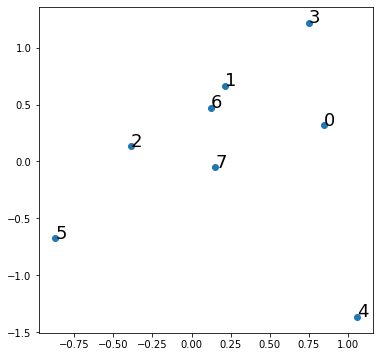

In [260]:
# Form a batch containing every message
batch_msg = tf.cast(tf.linspace(0., M-1, M), tf.int32)

p_b = autoencoder(batch_msg, training_snr)

msg_np = batch_msg.numpy()
x_np = autoencoder.x.numpy()
plt.figure(figsize=(6,6))
plt.scatter(np.real(x_np), np.imag(x_np))
for i in range(np.shape(x_np)[0]) :
    plt.text(np.real(x_np[i]), np.imag(x_np[i]), str(msg_np[i]), fontsize=18)

# Train

In [261]:
batch_size = 10000
epoch_size = 100
nb_epoch = 10
snr_training = 10

print('Symbol Error Rate after each epoch:')

#Initialize optimizer
optimizer = tf.keras.optimizers.Adam()

for epoch in range(nb_epoch):
    
    # Create a dataset for each epoch
    dataset = tf.data.Dataset.zip(generate_ds_msg(epoch_size, batch_size, M))

    # Iterate over the batches of the dataset.
    for step, (features, labels) in enumerate(dataset):
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            probas = autoencoder(features, snr_training)

            # Loss value for this batch.
            loss_value =  loss_func(y_true=labels, y_pred=probas)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, autoencoder.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_weights))
    
    #Take the argmax of the probability distribution as the estimated message
    m_hat = tf.argmax(probas, axis=1, output_type=tf.int32)
    
    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(labels-m_hat), 0, 1))/(batch_size)
    print(ser.numpy(), end=', ')

Symbol Error Rate after each epoch:
0.6852, 0.5747, 0.4687, 0.4089, 0.3615, 0.3231, 0.2734, 0.2377, 0.2173, 0.1985, 

## Evaluate the model

In [262]:
snr_range = np.arange(-5, 21)
results=[]
bs_eval = 100000

for eval_snr in snr_range:
    
    batch_msg = tf.random.uniform(shape=[bs_eval], minval=0, maxval=M, dtype=tf.int32)
    
    p_m = autoencoder(batch_msg, eval_snr)
    m_hat = tf.argmax(p_m, axis=1, output_type=tf.int32)
    
    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(batch_msg-m_hat), 0, 1))/(bs_eval)
    print(eval_snr, end=', ')
    results.append(ser.numpy())

-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

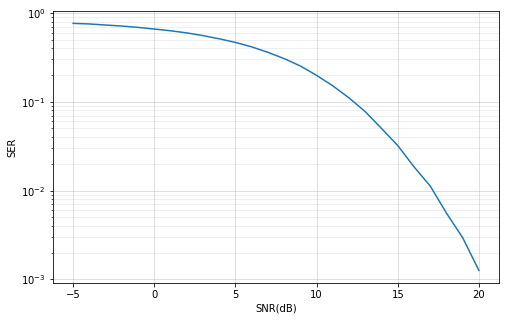

In [263]:
plt.figure(figsize=(8, 5))
plt.semilogy(snr_range, results)
plt.xlabel('SNR(dB)')
plt.ylabel('SER');
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.25)

## See learned constellation

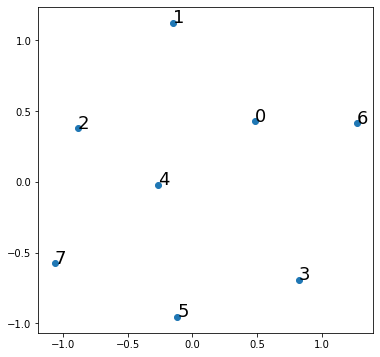

In [264]:
# Form a batch containing every message
batch_msg = tf.cast(tf.linspace(0., M-1, M), tf.int32)

p_b = autoencoder(batch_msg, training_snr)

msg_np = batch_msg.numpy()
x_np = autoencoder.x.numpy()
plt.figure(figsize=(6,6))
plt.scatter(np.real(x_np), np.imag(x_np))
for i in range(np.shape(x_np)[0]) :
    plt.text(np.real(x_np[i]), np.imag(x_np[i]), str(msg_np[i]), fontsize=18)